In [ ]:
# !pip install shap
# !pip install xgboost

     |████████████████████████████████| 193.6 MB 26.2 MB/s eta 0:00:01     |██████████████████████████▏     | 158.5 MB 48.0 MB/s eta 0:00:01     |██████████████████████████▌     | 160.2 MB 48.0 MB/s eta 0:00:01     |████████████████████████████▊   | 174.0 MB 48.0 MB/s eta 0:00:01
You should consider upgrading via the '/trinity/home/jyu/venv3/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
from __future__ import print_function
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv3D, MaxPooling3D, BatchNormalization, Dropout, GlobalAveragePooling3D
from tensorflow.keras.layers import Input, concatenate, multiply, add, Reshape, Lambda

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import shap
import pandas as pd
import numpy as np
import h5py

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

In [3]:
class LoadData:
    """
    Loading preprocessed data from .h5 file.
    Has to be similar to saving data function in data processing notebook.
    (Same names for datasets etc.)
    
    """
    def __init__(self, name):
        dataset_file = name+'.h5'
        
        f = h5py.File(DATASET_DIR+dataset_file, 'r')
#         f = h5py.File('/home/gennadyr/IPython/tests_john/version_age_3/models/'+dataset_file, 'r')
        
        self.fraction_train = f['fraction_train'][:]
        self.fraction_validation = f['fraction_validation'][:]
        self.fraction_test = f['fraction_test'][:]

        self.train_MRI_data = f['train_MRI_data'][:]
        self.validation_MRI_data = f['validation_MRI_data'][:]
        self.test_MRI_data = f['test_MRI_data'][:]
        
        gene_columns = f['gene_column_names'][:]
        
        train_gene_data = f['train_gene_data'][:]
        validation_gene_data = f['validation_gene_data'][:]
        test_gene_data = f['test_gene_data'][:]
        
        self.train_gene_data = pd.DataFrame(train_gene_data, columns=gene_columns)
        self.validation_gene_data = pd.DataFrame(validation_gene_data, columns=gene_columns)
        self.test_gene_data = pd.DataFrame(test_gene_data, columns=gene_columns)
        
        train_label_data1 = f['train_label_data1'][:]
        train_label_data2 = f['train_label_data2'][:]
        validation_label_data1 = f['validation_label_data1'][:]
        validation_label_data2 = f['validation_label_data2'][:]
        test_label_data1 = f['test_label_data1'][:]
        test_label_data2 = f['test_label_data2'][:]
        
        columns = f['label_column_names'][:]
        
        train_label_data2 = pd.DataFrame(train_label_data2)
        train_label_data2.columns = columns
        validation_label_data2 = pd.DataFrame(validation_label_data2)
        validation_label_data2.columns = columns
        test_label_data2 = pd.DataFrame(test_label_data2)
        test_label_data2.columns = columns
        
        train_label_data2['bigrfullname'] = train_label_data1
        validation_label_data2['bigrfullname'] = validation_label_data1
        test_label_data2['bigrfullname'] = test_label_data1

        self.train_label_data = train_label_data2
        self.validation_label_data = validation_label_data2
        self.test_label_data = test_label_data2

        f.close()

        print('Loaded datasets from '+DATASET_DIR+dataset_file)

In [285]:
def generate_riskset(event_times):
    """
    Generates the riskset for every individual. Riskset is the set of individuals that have a 
    longer event time and are thus at risk of experiencing the event : Tj>=Ti
    
    Input:
    - label_data = dataframe with file name, event times and other labels that do not get used
    
    Output:
    - riskset = square matrix in which row i is the riskset of individual i compared to all 
    individuals j. Entry is true if Tj>=Ti, so individual j is 'at risk'.
    """

    o = np.argsort(-event_times, kind="mergesort")
    n_samples = len(event_times)
    risk_set = np.zeros((n_samples, n_samples), dtype=np.bool_)
    for i_org, i_sort in enumerate(o):
        ti = event_times[i_sort]
        k = i_org
        while k < n_samples and ti == event_times[o[k]]:
            k += 1
        risk_set[i_sort, o[:k]] = True
    return risk_set


# **Function to normalize risk scores**

# In[36]:

def safe_normalize(x):
    """Normalize risk scores to avoid exp underflowing.

    Note that only risk scores relative to each other matter.
    If minimum risk score is negative, we shift scores so minimum
    is at zero.
    """
    x_min = tf.reduce_min(x, axis=0)
    c = tf.zeros_like(x_min)
    norm = tf.where(x_min < 0, -x_min, c)
    return x + norm


# **Function to calculate log of sum of exponent of predictions** (right hand side of equation 1.1)

# In[37]:

def logsumexp_masked(risk_scores, mask, axis = 0, keepdims= None):
    """
    Computes the log of the sum of the exponent of the predictions across `axis` 
    for all entries where `mask` (riskset) is true:
    
    log(sum(e^h_j))
    
    where h_j are the predictions of patients at risk of developing dementia (T_j>=T_i)
    
    Inputs:
    - risk_scores = the predictions from the network of patients h_j
    - mask = a mask to select which patients are at risk
    
    Output:
    - output = right hand part of the NPLL (Negative Partial Log Likelihood)

    """
    risk_scores.shape.assert_same_rank(mask.shape)

    with tf.name_scope("logsumexp_masked"):
        risk_scores = tf.cast(risk_scores,tf.float32)
        mask_f = tf.cast(mask, risk_scores.dtype)
        risk_scores_masked = tf.math.multiply(risk_scores, mask_f)

        #for numerical stability, substract the maximum value
        #before taking the exponential
        amax = tf.reduce_max(risk_scores_masked, axis=axis, keepdims=True)
        risk_scores_shift = risk_scores_masked - amax
        exp_masked = tf.math.multiply(tf.math.exp(risk_scores_shift), mask_f)
        exp_sum = tf.reduce_sum(exp_masked, axis=axis, keepdims=True)
        
        #turn 0's to 1's to get rid of inf loss (log(0) = inf)
        condition = tf.not_equal(exp_sum, 0)   
        exp_sum_clean = tf.where(condition, exp_sum, tf.ones_like(exp_sum))

        output = amax + tf.math.log(exp_sum_clean)
        if not keepdims:
            output = tf.squeeze(output, axis=axis)

    return output


# **Custom loss function** (Negative Partial Log Likelihood)

# In[38]:

def CoxPH_loss(y_true, y_pred):
    """
    Calculates the Negative Partial Log Likelihood:
    
    L = sum(h_i - log(sum(e^h_j)))
    
    where;
        h_i = risk prediction of patient i
        h_j is risk prediction of patients j at risk of developing dementia (T_j>=T_i)
    
    Inputs: 
    - y_true = label data composed of 
        y_event: A 1 or 0 indicating if the patient developed dementia or not, and
        y_riskset:(set of patients j which are at risk dependent on patient i (Tj>=Ti)). 
        
    - y_pred = the risk prediction of the network
    
    Output:
    - loss = the loss used to optimize the network
    
    """
    event = y_true[:,0]
    event = tf.reshape(event,(-1,1))

    riskset_loss = y_true[:,1:]
    predictions = y_pred
    predictions = tf.cast(predictions,tf.float32)
    riskset_loss = tf.cast(riskset_loss,tf.bool)
    event = tf.cast(event, predictions.dtype)
    predictions = safe_normalize(predictions)

#    with tf.name_scope("assertions"):
#        assertions = (
#            tf.debugging.assert_less_equal(event, 1.),
#            tf.debugging.assert_greater_equal(event, 0.),
#            tf.debugging.assert_type(riskset_loss, tf.bool)
#        )

    # move batch dimension to the end so predictions get broadcast
    # row-wise when multiplying by riskset
    pred_t = tf.transpose(predictions)
    # compute log of sum over risk set for each row
    rr = logsumexp_masked(pred_t, riskset_loss, axis=1, keepdims=True)
#    print(predictions.shape.as_list())
#    assert rr.shape.as_list() == predictions.shape.as_list()

    loss = tf.math.multiply(event, rr - predictions)
    
    return loss

In [286]:
### 11 features
def submodel():
    model = tf.keras.models.load_model(MODEL_DIR+'model_'+version+'.h5', custom_objects={'CoxPH_loss': CoxPH_loss})
    input1 = Input((11,))# MRI input
    x = input1
    for layer in model.layers[-4:-1]: # loop over convolutional layers from [1] and add to model
        # connect the layers
        x = layer(x)
    
    final= model.layers[-1](x)
    model = Model(inputs=[input1], outputs=final)

    adam_opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    model.compile(loss=CoxPH_loss, optimizer=adam_opt)
    return model

In [287]:
### 7 features and SNPs
def submodel():
    model = tf.keras.models.load_model(MODEL_DIR+'model_'+version+'.h5', custom_objects={'CoxPH_loss': CoxPH_loss})
    input1 = Input((7,))
    input2 = Input((76,))# MRI input
    x1= model.layers[-6](input2)
    x = concatenate([input1, x1])
    for layer in model.layers[-4:-1]: # loop over convolutional layers from [1] and add to model
        # connect the layersxx
        x = layer(x)
    
    final= model.layers[-1](x)
    model = Model(inputs=[input1,input2], outputs=final)

    adam_opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    model.compile(loss=CoxPH_loss, optimizer=adam_opt)
    return model

In [283]:
version = 'MRI_SNP_TFS_FS_l_1'

MODEL_DIR = '/trinity/home/jyu/DeepSurvival/models/RS+MCICASES_FS_59_5cv/MRI/'
DATASET_DIR = '/data/scratch/jyu/DeepSurvival/data/'
prepdata_name = 'Total_fs_RS_cv_split_1'   

Loaded datasets from /data/scratch/jyu/DeepSurvival/data/Total_fs_RS_cv_split_1.h5


In [288]:
model1=submodel()

The `lr` argument is deprecated, use `learning_rate` instead.


In [289]:
data = LoadData(prepdata_name)

#prep full RS datasets
# Train
train_MRI_set = data.train_MRI_data
train_MRI_set=np.char.decode(train_MRI_set)

train_label_set = data.train_label_data
b=train_label_set['bigrfullname'].str.decode("utf-8")
train_label_set['bigrfullname']=1
train_label_set['bigrfullname']=b
train_label_set = train_label_set.set_index('bigrfullname')
train_label_set.columns=train_label_set.columns.str.decode("utf-8")
train_label_set['ergoid']=train_label_set['ergoid'].astype('int')

columnsname=['age']
mean=train_label_set[columnsname].mean()
std=train_label_set[columnsname].std()

train_label_set[columnsname]=(train_label_set[columnsname]-mean)/std

train_gene_data = data.train_gene_data
train_gene_data.columns=train_gene_data.columns.str.decode("utf-8")
train_gene_data['ergoid']=train_gene_data['ergoid'].astype('int')
train_gene_data = train_gene_data.set_index('ergoid')



test_MRI_set = data.test_MRI_data
test_MRI_set=np.char.decode(test_MRI_set)

test_label_set = data.test_label_data
b=test_label_set['bigrfullname'].str.decode("utf-8")
test_label_set['bigrfullname']=1
test_label_set['bigrfullname']=b
test_label_set = test_label_set.set_index('bigrfullname')
test_label_set.columns=test_label_set.columns.str.decode("utf-8")
test_label_set['ergoid']=test_label_set['ergoid'].astype('int')

test_label_set[columnsname]=(test_label_set[columnsname]-mean)/std

test_gene_data = data.test_gene_data
test_gene_data.columns=test_gene_data.columns.str.decode("utf-8")
test_gene_data['ergoid']=test_gene_data['ergoid'].astype('int')
test_gene_data = test_gene_data.set_index('ergoid')


train_label_set=train_label_set.merge(train_gene_data,on='ergoid')
test_label_set=test_label_set.merge(test_gene_data,on='ergoid')



train_label_set=train_label_set.sort_values(['age','ergoid']).drop_duplicates('ergoid')
train=pd.read_csv('../Plot/output/features_5fold/train_features_TFS_1.csv')
train=train.loc[train_label_set.index]


test_label_set=test_label_set.sort_values(['ergoid','age']).drop_duplicates('ergoid')
features=pd.read_csv('../Plot/output/features_5fold/test_features_TFS_1.csv')
X=features[['img.f1','img.f2','img.f3','img.f4','sex','age','apoe','gen.f1','gen.f2','gen.f3','gen.f4']]  
X=X.loc[test_label_set.index]
X[columnsname]=(X[columnsname]-mean)/std

In [148]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)

explainer = shap.DeepExplainer(model1,np.array(train))
shap_values = explainer.shap_values(np.array(X))

In [306]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
train=pd.concat([train[['img.f1','img.f2','img.f3','img.f4','sex','age','apoe']],train_label_set.iloc[:,-76:]],axis=1)
X=pd.concat([X[['img.f1','img.f2','img.f3','img.f4','sex','age','apoe']],test_label_set.iloc[:,-76:]],axis=1)

X1=X.iloc[:,-76:]
X2=X.iloc[:,:7]

explainer = shap.DeepExplainer(model1,[np.array(train.iloc[:,:7]),np.array(train.iloc[:,-76:])])
shap_values = explainer.shap_values([np.array(X2),np.array(X1)])

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


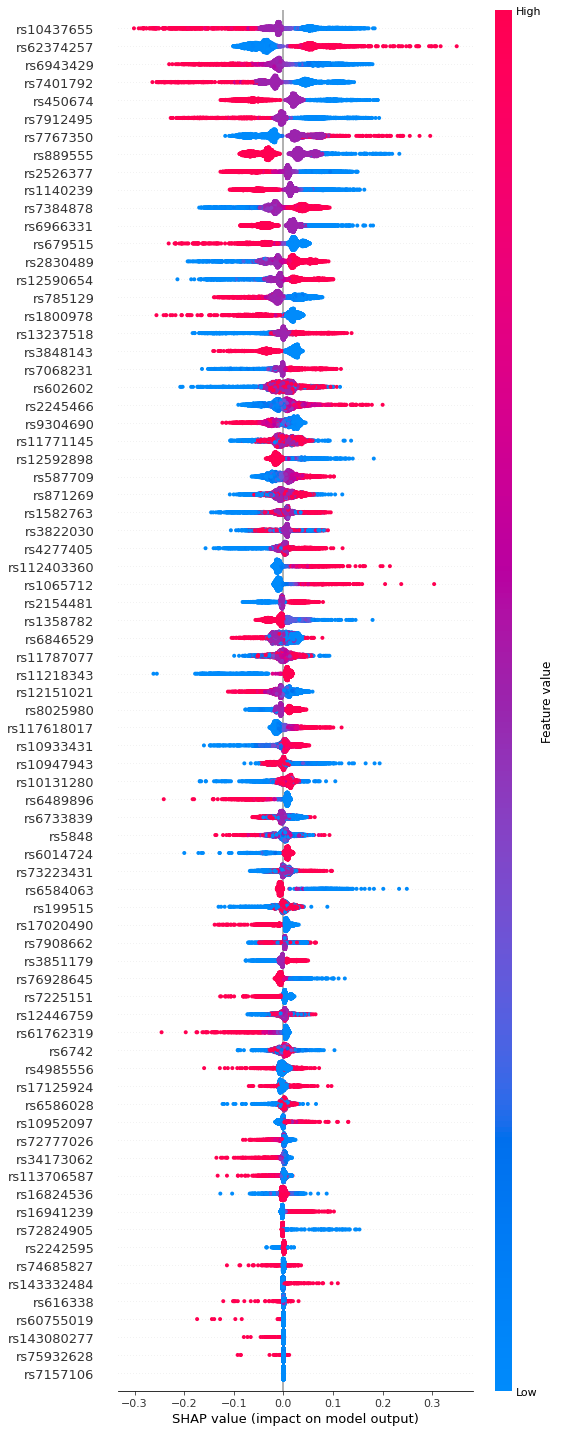

In [639]:
shap.summary_plot(shap_values[0][1], X1, plot_type='dot',max_display=76, plot_size=(8,20),sort=True,color_bar_label='Feature value')
                                                                    


In [ ]:
genetic=pd.read_csv('genetic_shap.csv')
beta=pd.read_csv('/data/scratch/jyu/DeepSurvival/dataset/snp/NewGWAS-83snps.csv')[['SNP','BETA','P value']]
beta=beta.set_index('SNP')
# #beta['BETA'] = np.log(beta['BETA'])
# beta=beta[~beta.index.isin(MAF_5[1])]
# #beta['OR'] = np.exp(beta['BETA'])
beta=beta.loc[genetic.Input]
beta['SHAP_1']=genetic.shap1.tolist()
beta['SHAP_all']=genetic.shapall.tolist()
beta['SHAP_all1']=genetic.shapall1.tolist()
#beta['MAF']=fsnp.tolist()

beta['std']=std
beta = beta.fillna(0)


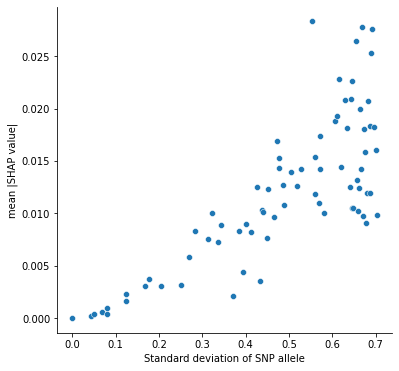

In [327]:
fig, ax = plt.subplots(figsize=(6,6))
p1=sns.scatterplot(x='std', y='SHAP_all',data=beta)
# for line in range(0,beta.shape[0]):
#      p1.text(beta['std'][line]+0.001, beta.SHAP_all1[line]-0.001, 
#      beta.index[line], horizontalalignment='left', 
#      size=8, color='black', weight='semibold')

plt.xlabel('Standard deviation of SNP allele')
plt.ylabel('mean |SHAP value|')
sns.despine()


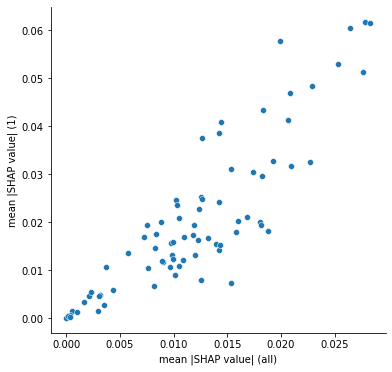

In [191]:
fig, ax = plt.subplots(figsize=(6,6))
p1=sns.scatterplot(x='SHAP_all', y='SHAP_1',data=beta)
# for line in range(0,beta.shape[0]):
#      p1.text(beta.SHAP_all[line]+0.0001, beta.SHAP_1[line], 
#      beta.index[line], horizontalalignment='left', 
#      size=8, color='black', weight='semibold')

plt.xlabel('mean |SHAP value| (all)')
plt.ylabel('mean |SHAP value| (1)')
sns.despine()


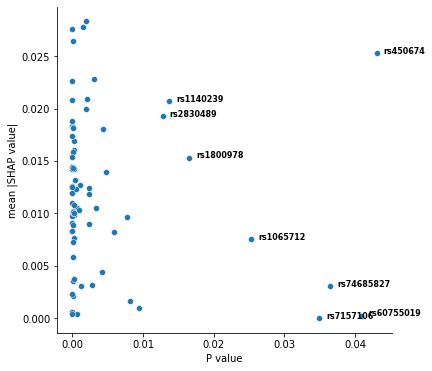

In [196]:
beta1=beta[beta['P value']>0.01]
fig, ax = plt.subplots(figsize=(6,6))
p1=sns.scatterplot(x='P value', y='SHAP_all',data=beta)
for line in range(0,beta1.shape[0]):
     p1.text(beta1['P value'][line]+0.001, beta1.SHAP_all[line], 
     beta1.index[line], horizontalalignment='left', 
     size=8, color='black', weight='semibold')

plt.xlabel('P value')
plt.ylabel('mean |SHAP value|')
sns.despine()


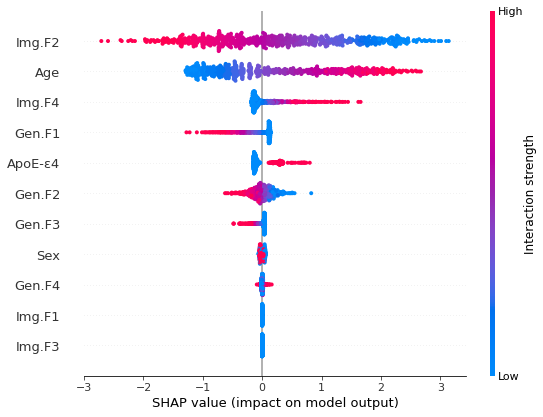

In [16]:
shap.summary_plot(shap_values[0], X, plot_type='dot', color_bar_label='Interaction strength',color='blue')

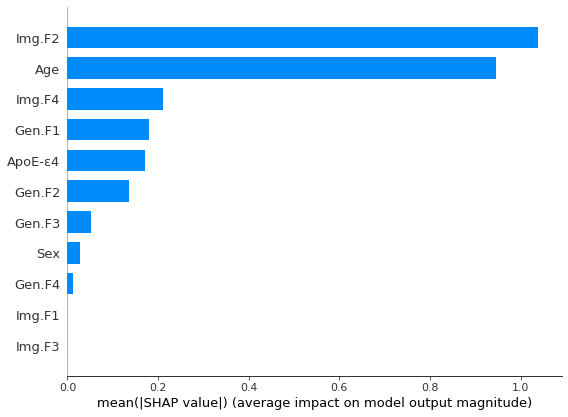

In [111]:
shap.summary_plot(shap_values[0], X, plot_type='bar')


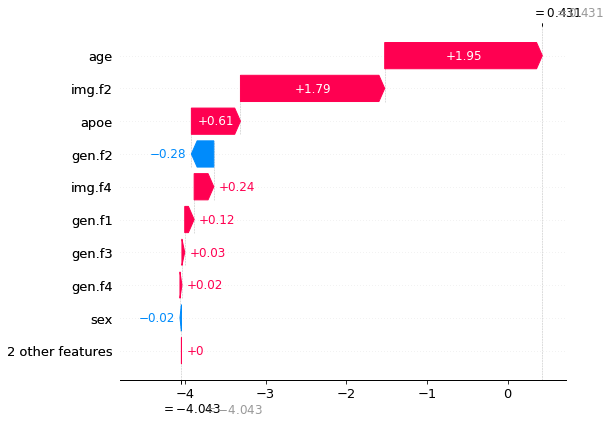

In [25]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0].numpy(), shap_values[0][1], feature_names = X.columns)

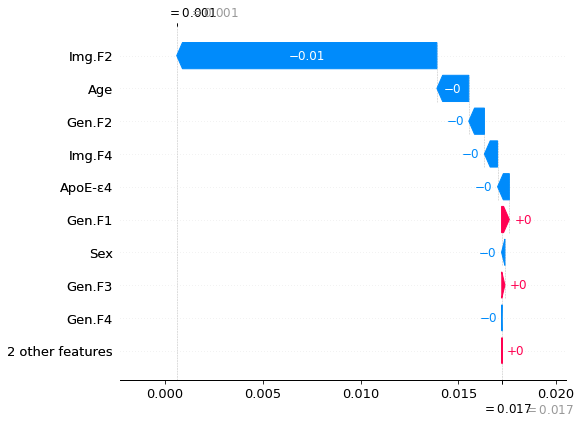

In [56]:
shap.plots._waterfall.waterfall_legacy(1/(1+np.exp(-explainer.expected_value[0].numpy())), shap_values1[0][429], feature_names = X.columns)

In [51]:
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][1,:], X.iloc[1,:], link="logit")


In [55]:
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(), shap_values[0][429,:], X.iloc[429,:], link="logit")


In [82]:
X['Age']=std[0]*X['Age']+mean[0]

Text(0, 0.5, 'SHAP value')

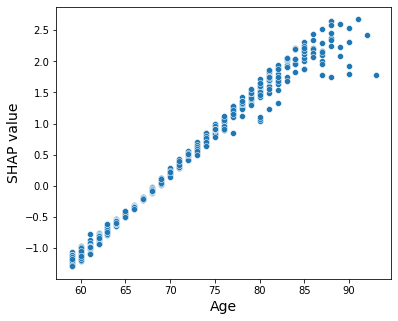

In [115]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=X['Age'].tolist(),y=shap_values[0][:,5])

plt.xlabel('Age',size=14)
# Set y-axis label
plt.ylabel('SHAP value',size=14)

Text(0, 0.5, 'SHAP value')

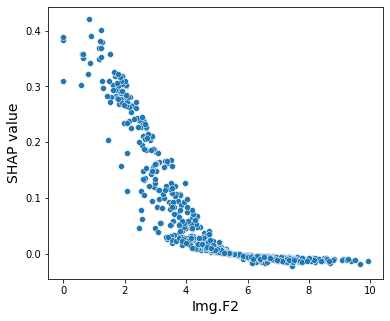

In [131]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=X['Img.F2'].tolist(),y=shap_values[0][:,1])

plt.xlabel('Img.F2',size=14)
# Set y-axis label
plt.ylabel('SHAP value',size=14)

Text(0, 0.5, 'SHAP value')

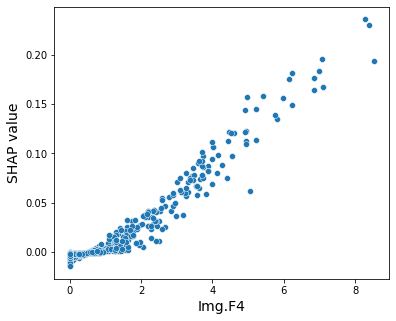

In [132]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=X['Img.F4'].tolist(),y=shap_values[0][:,3])

plt.xlabel('Img.F4',size=14)
# Set y-axis label
plt.ylabel('SHAP value',size=14)

Text(0, 0.5, 'SHAP value')

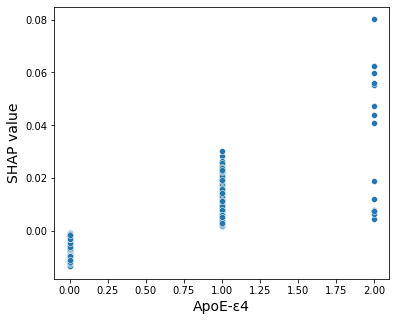

In [143]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=X['ApoE-ε4'].tolist(),y=shap_values[0][:,6])

plt.xlabel('ApoE-ε4',size=14)
# Set y-axis label
plt.ylabel('SHAP value',size=14)

Text(0, 0.5, 'SHAP value')

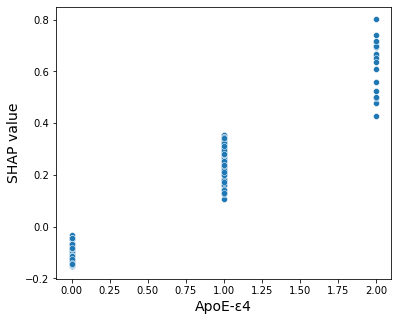

In [138]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=X['ApoE-ε4'].tolist(),y=shap_values[0][:,6])

plt.xlabel('ApoE-ε4',size=14)
# Set y-axis label
plt.ylabel('SHAP value',size=14)

Text(0, 0.5, 'SHAP value')

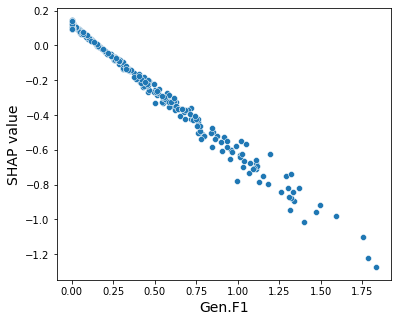

In [224]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=X['Gen.F1'].tolist(),y=shap_values[0][:,-4])

plt.xlabel('Gen.F1',size=14)
# Set y-axis label
plt.ylabel('SHAP value',size=14)

Text(0, 0.5, 'SHAP value')

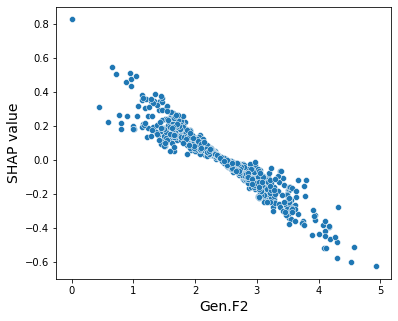

In [225]:
plt.figure(figsize=(6,5))
sns.scatterplot(x=X['Gen.F2'].tolist(),y=shap_values[0][:,-3])

plt.xlabel('Gen.F2',size=14)
# Set y-axis label
plt.ylabel('SHAP value',size=14)

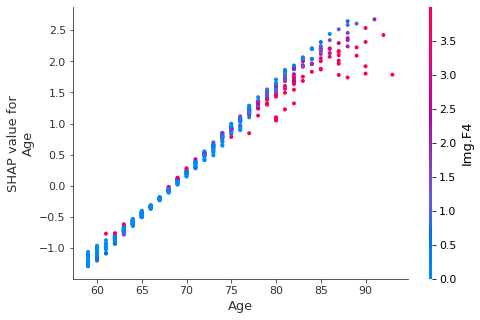

In [210]:
shap.dependence_plot("Age",shap_values[0], X)

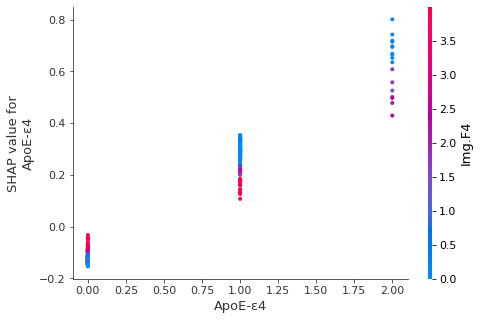

In [211]:
shap.dependence_plot("ApoE-ε4",shap_values[0], X)

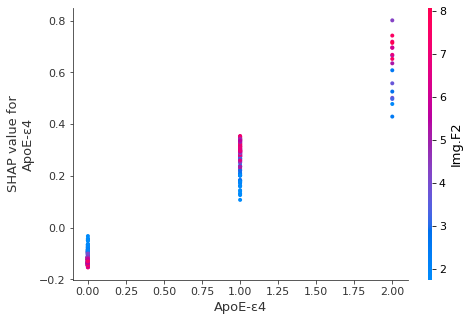

In [84]:
shap.dependence_plot("ApoE-ε4",shap_values[0][:,[1,6]], X.iloc[:,[1,6]])

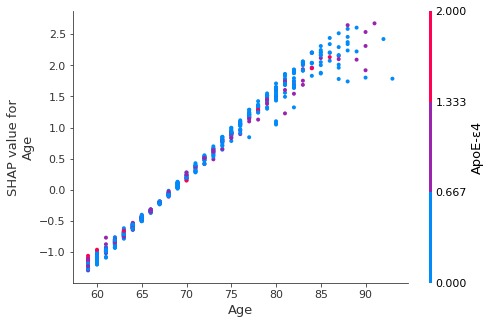

In [213]:
shap.dependence_plot("Age",shap_values[0][:,[5,6]], X.iloc[:,[5,6]])

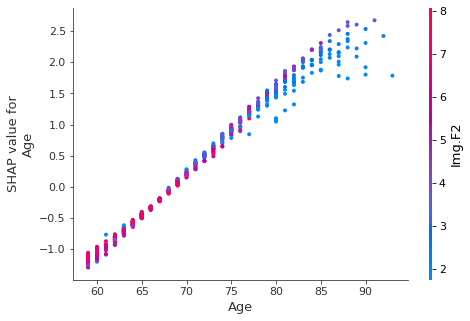

In [83]:
shap.dependence_plot("Age",shap_values[0][:,[1,5]], X.iloc[:,[1,5]])

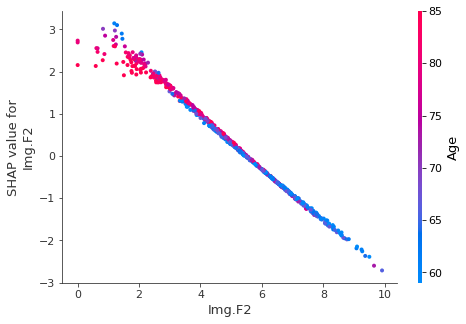

In [214]:
shap.dependence_plot("Img.F2",shap_values[0][:,[1,5]], X.iloc[:,[1,5]])

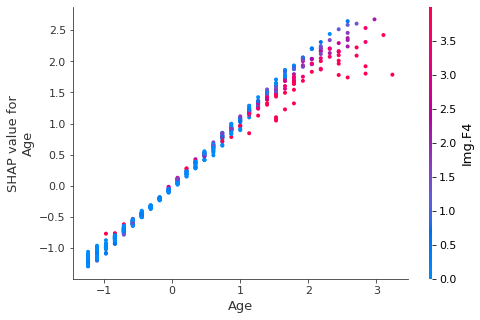

In [75]:
shap.dependence_plot("Age",shap_values[0][:,[3,5]], X.iloc[:,[3,5]])

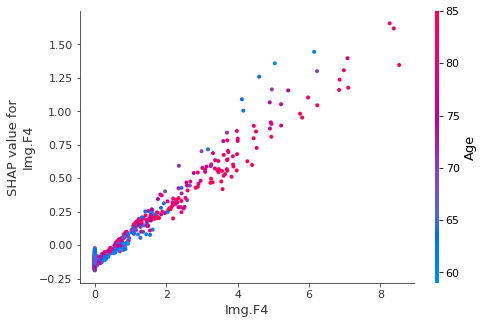

In [216]:
shap.dependence_plot("Img.F4",shap_values[0][:,[3,5]], X.iloc[:,[3,5]])

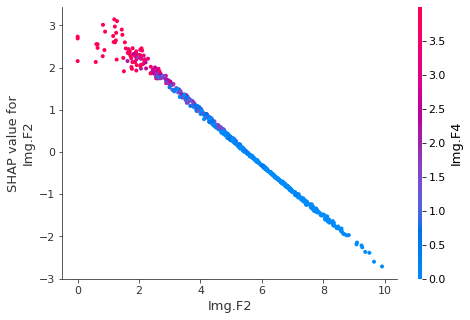

In [217]:
shap.dependence_plot("Img.F2",shap_values[0][:,[1,3]], X.iloc[:,[1,3]])

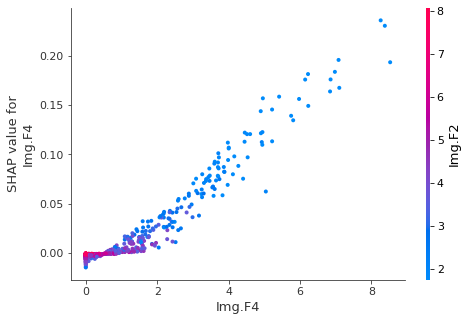

In [35]:
shap.dependence_plot("Img.F4",shap_values[0][:,[1,3]], X.iloc[:,[1,3]])

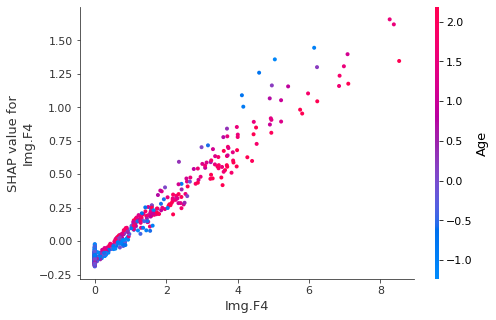

In [81]:
shap.dependence_plot("Img.F4",shap_values[0][:,[3,5]], X.iloc[:,[3,5]])

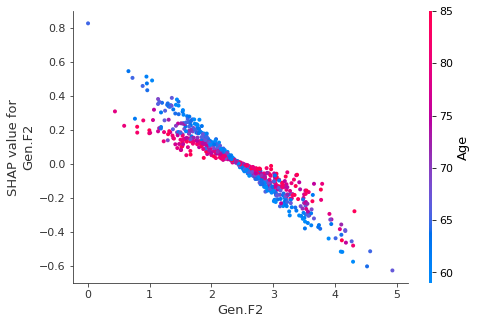

In [223]:

shap.dependence_plot("Gen.F2",shap_values[0][:,[8,5]], X.iloc[:,[8,5]])

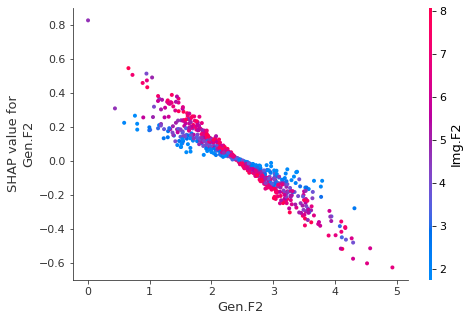

In [220]:
shap.dependence_plot("Gen.F2",shap_values[0][:,[8,1]], X.iloc[:,[8,1]])

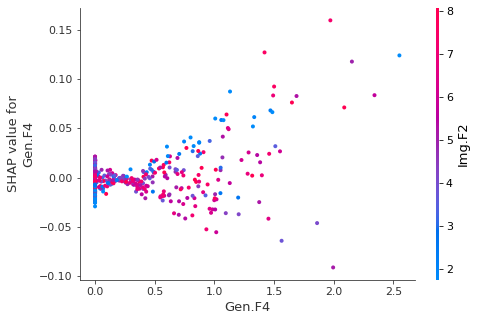

In [227]:
shap.dependence_plot("Gen.F4",shap_values[0][:,[-1,1]], X.iloc[:,[-1,1]])

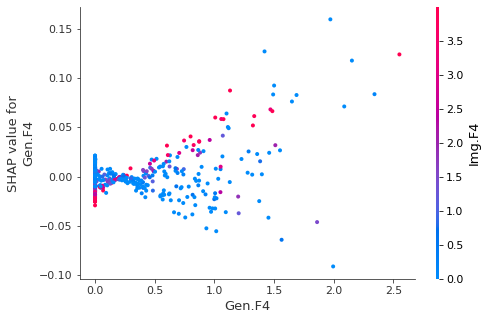

In [226]:
shap.dependence_plot("Gen.F4",shap_values[0][:,[-1,3]], X.iloc[:,[-1,3]])

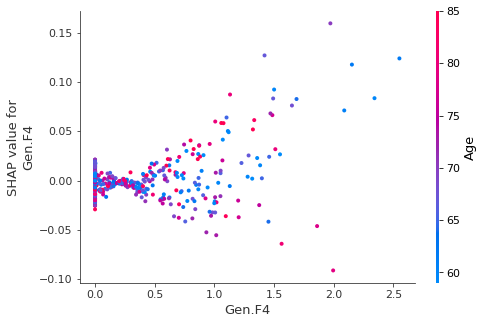

In [228]:
shap.dependence_plot("Gen.F4",shap_values[0][:,[-1,5]], X.iloc[:,[-1,5]])

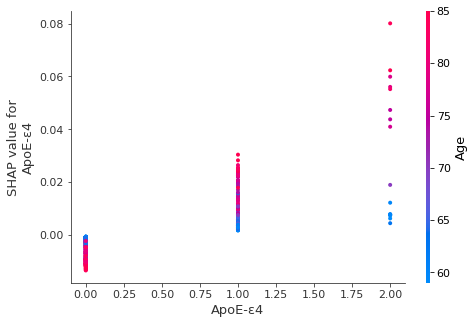

In [86]:
shap.dependence_plot("ApoE-ε4",shap_values1[0][:,[5,6]], X.iloc[:,[5,6]])

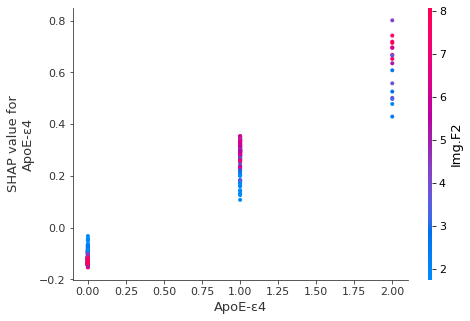

In [229]:
shap.dependence_plot("ApoE-ε4",shap_values[0][:,[1,6]], X.iloc[:,[1,6]])

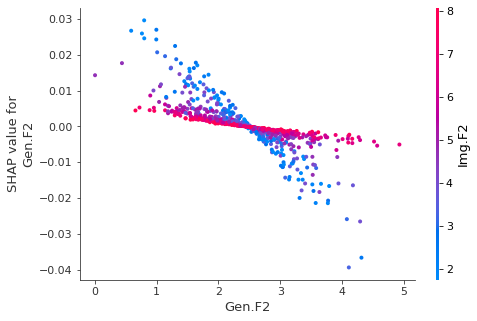

In [182]:
shap.dependence_plot("Gen.F2",shap_values[0][:,[1,8]], X.iloc[:,[1,8]])

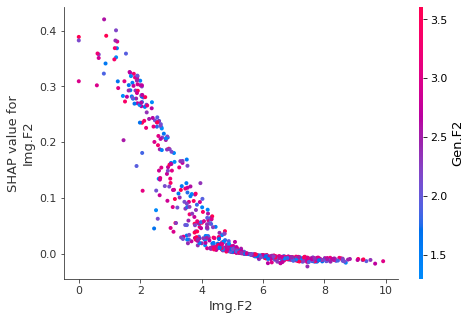

In [201]:
shap.dependence_plot("Img.F2",shap_values[0][:,[1,8]], X.iloc[:,[1,8]])

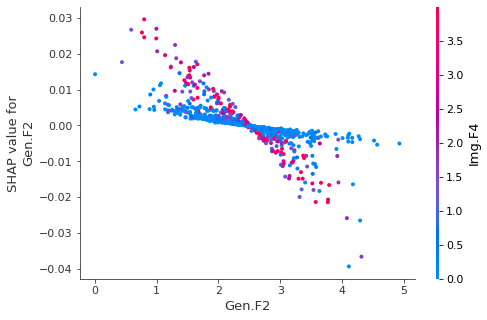

In [183]:
shap.dependence_plot("Gen.F2",shap_values[0][:,[3,8]], X.iloc[:,[3,8]])

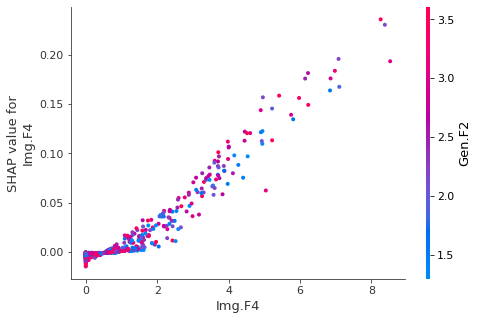

In [36]:
shap.dependence_plot("Img.F4",shap_values[0][:,[3,8]], X.iloc[:,[3,8]])